# Training Model for Seul Bike Rental prediction

In [84]:
# Import Libraries
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_log_error, make_scorer
from sklearn.inspection import permutation_importance
from matplotlib import pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
import warnings
# Import mlflow
import mlflow
import mlflow.sklearn
warnings.filterwarnings("ignore")
from sklearn.linear_model import ElasticNet
from urllib.parse import urlparse
import logging
from joblib import dump

logging.basicConfig(level=logging.WARN)
logger = logging.getLogger(__name__)

In [85]:
X_TRAIN_PATH = "E:\My_APP\data\preprocesseddata\X_train.pkl"
X_VAL_PATH = "E:\My_APP\data\preprocesseddata\X_val.pkl"
X_TEST_PATH = "E:\My_APP\data\preprocesseddata\X_test.pkl"

Y_TRAIN_PATH = "E:\My_APP\data\preprocesseddata\y_train.pkl"
Y_VAL_PATH = "E:\My_APP\data\preprocesseddata\y_val.pkl"

# Reading pickles files 
X_train = pd.read_pickle(X_TRAIN_PATH)
X_val = pd.read_pickle(X_VAL_PATH)
X_test = pd.read_pickle(X_TEST_PATH)

y_train = pd.read_pickle(Y_TRAIN_PATH)
y_val = pd.read_pickle(Y_VAL_PATH)


In [86]:
X_train.head()

,Hour,Temperature,Humidity,Wind speed,Dew point temperature,Solar Radiation,Rainfall,Holiday,Functioning Day,Year,...,"hour_range_(12.0, 15.0]","hour_range_(15.0, 18.0]","hour_range_(18.0, 21.0]","hour_range_(21.0, 24.0]","month_range_(0.999, 4.0]","month_range_(4.0, 8.0]","month_range_(8.0, 12.0]","day_range_(-0.001, 2.0]","day_range_(2.0, 4.0]","day_range_(4.0, 6.0]"
5164,4,11.0,69,0.6,5.5,0.000000,0.0,1,1,1,...,0,0,0,0,0,0,1,1,0,0
4987,19,16.4,42,1.8,3.4,0.000000,0.0,1,1,1,...,0,0,1,0,0,1,0,0,1,0
5570,2,5.6,64,0.1,-0.6,0.000000,0.0,1,1,1,...,0,0,0,0,0,0,1,1,0,0
443,11,-3.5,35,2.2,-16.7,0.932738,0.0,1,1,0,...,0,0,0,0,0,0,1,1,0,0
1084,4,-12.0,36,2.7,-24.0,0.000000,0.0,1,1,1,...,0,0,0,0,0,1,0,0,0,1


## Building Model

In [87]:
regressors = {'Random Forest' : RandomForestRegressor(n_estimators = 15,\
                                 max_depth = 10, random_state = 0),
               'GradientBoostingRegressor' :\
               GradientBoostingRegressor(n_estimators = 280,\
                  max_depth = 5, max_leaf_nodes = 60,\
                  loss = "huber", random_state = 0)}


### ML_FLOW

In [88]:
def train_rgrs(X_train, X_val, y_train, y_val, classifiers):
    
    logging.basicConfig(level=logging.WARN)
    logger = logging.getLogger(__name__)
    
    names_rgrs = []
    results_train_cv_accuracy = []
    results_val_accuracy = []

    for name_rgr, rgr in regressors.items():
        with mlflow.start_run(run_name=f"{name_rgr}"):
            print(f'Classifier: {name_rgr}\n')

            pipeline = Pipeline([('clf', rgr)])
            
            cv_acc = cross_val_score(pipeline, X_train, y_train, cv=10)        
            
            pipeline.fit(X_train, y_train)        
            #y_pred = pipeline.predict(X_val)
            
            names_rgrs.append(name_rgr)
            results_train_cv_accuracy.append(cv_acc)
            results_val_accuracy.append(rgr.score(X_val, y_val))
       
            print(f'CV\t-\taccuracy:\t{round(cv_acc.mean(), 3)}')
         
            print(f'Validation\t-\taccuracy:\t{round(rgr.score(X_val, y_val), 3)}')      
            print('\n<-------------------------->\n')

            # Log mlflow attributes for mlflow UI

            mlflow.log_metric('CV-accuracy',round(cv_acc.mean(), 3))
         
            mlflow.log_metric('Validation-accuracy',round(rgr.score(X_val, y_val), 3))
            mlflow.sklearn.log_model(pipeline, "model")
            tracking_url_type_store = urlparse(mlflow.get_tracking_uri()).scheme

            # Model registry does not work with file store
            if tracking_url_type_store != "file":
                # Register the model
                # There are other ways to use the Model Registry, which depends on the use case,
                # please refer to the doc for more information:
                # https://mlflow.org/docs/latest/model-registry.html#api-workflow
                mlflow.sklearn.log_model(rgr, "model", registered_model_name="ElasticnetWineModel")
            else:
                mlflow.sklearn.log_model(rgr, "model")
            
    df_results_test = pd.DataFrame(index=[names_rgrs], columns=['ACCURACY'])
    df_results_test['ACCURACY'] = results_val_accuracy

    return df_results_test

### Model evaluation

In [89]:
df_results = train_rgrs(X_train, X_val, y_train, y_val, classifiers)

Classifier: Random Forest

CV	-	accuracy:	0.933
Validation	-	accuracy:	0.941

<-------------------------->

Classifier: GradientBoostingRegressor

CV	-	accuracy:	0.949
Validation	-	accuracy:	0.964

<-------------------------->



In [90]:
def plot_test(df, xlim_min, xlim_max):

    color = ['blue', 'red', 'green', 'yellow', 'orange', 'purple', 'navy', 'turquoise', 'darkorange']

    df['ACCURACY'].plot(kind='barh',xlim=(xlim_min, xlim_max), title='ACCURACY', color=color)
    plt.show()

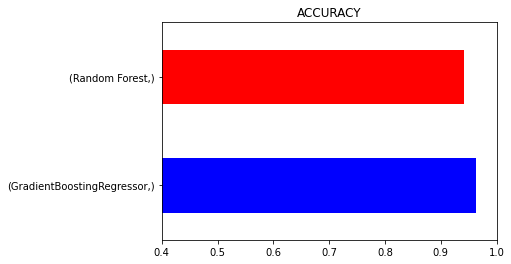

In [91]:
df_plot = df_results.sort_values('ACCURACY', ascending=False).head(3)
plot_test(df_plot, 0.4, 1)

## Saving Model

In [92]:
X_train.columns

Index(['Hour', 'Temperature', 'Humidity', 'Wind speed',
       'Dew point temperature', 'Solar Radiation', 'Rainfall', 'Holiday',
       'Functioning Day', 'Year', 'day', 'Weekday', 'Month', 'Hot',
       'isOfficeHour', 'weekend', 'Hour_sin', 'Remaining_Seasons',
       'Sunday_Saturday', 'Remaining_Weekday', 'Yes_Noholiday',
       'Seasons_Autumn', 'Seasons_Spring', 'Seasons_Summer', 'Seasons_Winter',
       'hour_range_(-0.001, 3.0]', 'hour_range_(3.0, 6.0]',
       'hour_range_(6.0, 9.0]', 'hour_range_(9.0, 12.0]',
       'hour_range_(12.0, 15.0]', 'hour_range_(15.0, 18.0]',
       'hour_range_(18.0, 21.0]', 'hour_range_(21.0, 24.0]',
       'month_range_(0.999, 4.0]', 'month_range_(4.0, 8.0]',
       'month_range_(8.0, 12.0]', 'day_range_(-0.001, 2.0]',
       'day_range_(2.0, 4.0]', 'day_range_(4.0, 6.0]'],
      dtype='object')

In [93]:
pipeline = Pipeline([ ('GradientBoostingRegressor' ,\
                     GradientBoostingRegressor(n_estimators = 280,\
                    max_depth = 5, max_leaf_nodes = 60,\
                    loss = "huber", random_state = 0))])


X_train=X_train[['Month', 'day', 'Hour', 'Functioning Day', 'Temperature',\
                'Humidity', 'Dew point temperature']]
pipeline.fit(X_train, y_train)


dump(pipeline, 'E://My_APP//SeulBike_model.joblib')


['E://My_APP//SeulBike_model.joblib']